# Assignment 3 - CS3920

In [69]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt

import numpy as np

In [70]:
CV: int = 3
RANDOM_STATE: int = 3103

# 1 - Load Datasets

## Loading Wine Dataset

In [71]:
wine: np.ndarray = load_wine()
X_wine: np.ndarray = wine.data
y_wine: np.ndarray = wine.target

## Loading USPS Dataset

In [72]:
DATA_SPLIT: int = 10 # percentage of data to be used 

In [73]:
zip_train: np.ndarray = np.genfromtxt('zip.train', delimiter=' ')
zip_train = zip_train[::DATA_SPLIT]

zip_test: np.ndarray = np.genfromtxt('zip.test', delimiter=' ')
zip_test = zip_test[::DATA_SPLIT]

zip_data: np.ndarray = np.concatenate((zip_train, zip_test), axis=0)
zip_data = zip_data[::DATA_SPLIT]

X_zip: np.ndarray = zip_data[:, 1:]
y_zip: np.ndarray = zip_data[:, 0]

In [74]:
del zip_train, zip_test

# 2 - Split Datasets 

- This functions splits the dataset into training set and test set for each matrix of features `X` and labels  `y`
- It takes the features `X` and labels `y` and returns the split data

In [75]:
def split(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray[float]]:
	"""Splits the dataset into training and testing sets.

	Args:
		X (np.ndarray): matrix of features
		y (np.ndarray): labels 

	Returns:
		tuple[np.ndarray[float]]: X and y training and testing sets (4 in total)
	"""	
	return train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
	

## Splitting Wine Dataset

In [76]:
X_wine_train, X_wine_test, y_wine_train, y_wine_test = split(X_wine, y_wine)

## Splitting USPS Dataset

In [77]:
X_zip_train, X_zip_test, y_zip_train, y_zip_test = split(X_zip, y_zip)

# 3 - Cross Validation

## Cross Validate Wine

In [78]:
svm: SVC = SVC()
scores_wine: np.ndarray[float] = cross_val_score(svm, X_wine_train, y_wine_train, cv=CV)
print("Cross-validation scores: ", scores_wine)
print("Average cross-validation score: ", scores_wine.mean())

Cross-validation scores:  [0.64285714 0.63414634 0.68292683]
Average cross-validation score:  0.6533101045296168


## Cross Validate USPS

In [79]:
score_zip: np.ndarray[float] = cross_val_score(svm, X_zip_train, y_zip_train, cv=CV)
print("Cross-validation scores: ", score_zip)
print("Average cross-validation score: ", score_zip.mean())

Cross-validation scores:  [0.63636364 0.72727273 0.61904762]
Average cross-validation score:  0.660894660894661


# 4 - Test Error Rate of `SVM`

## Test Wine

In [80]:
svm.fit(X_wine_train, y_wine_train)
print("Test error rate: ", 1 - svm.score(X_wine_test, y_wine_test))

Test error rate:  0.2777777777777778


## Test USPS

In [81]:
svm.fit(X_zip_train, y_zip_train)
print("Test error rate: ", 1 - svm.score(X_zip_test, y_zip_test))

Test error rate:  0.4482758620689655


# 5 - Pipeline

## Dictionary of Hyperparameters

- Dictionary containing a grid of hyperparameters to be used in a grid search.
- The grid contains two hyperparameters: 
  - `C` (`svc__C`) - determines the strength of regularization, or the penalty applied to the model for making incorrect predictions
    - Larger gamma value means that the model is more non-linear, resulting in a more complex and potentially overfitting model
    - Smaller gamma value means that the model is more linear, resulting in a simpler and potentially underfitting model
  - `gamma` (`svc__gamma`) - determines the strength of the non-linearity of the model
    - Larger gamma value means that the model is more non-linear, resulting in a more complex and potentially overfitting model
    - Smaller gamma value means that the model is more linear, resulting in a simpler and potentially underfitting model

In [82]:
param_grid: dict[str, list[float]] = {
	'svc__C': [0.001, 0.01, 0.1, 1, 10, 100], 
	'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

- Creates a pipeline with Support Vector Correlation (SVC) and some specified scaler (normalizer)
- It takes the training and test data
- Uses Grid Search and Cross-Validation to tune parameters `C` and `gamma`

## Algorithm

- Creates a model that uses a support vector machine (SVM) classifier with a scaler and performs a grid search
- Uses a pipeline to chain the scaler and the `SVM` classifier
- There are several methods:
  - `best_score` - Computes the score of the predictions made on the test set
    - Can be used to compare the performance of different models or to choose the final model to use for making predictions on new data
  - `best_params` - Identifies the set of hyperparameters that produce the best performance.
    - Can be used to choose the final model to use for making predictions on new data
  - `test_score` - Computes the score of the predictions made on the test set
    - It applies the trained model to the test data and returns a score that indicates how well the model is able to make predictions on the test data
    - Can then be used to choose the final model to use for making predictions on new data
  - `error_rate` - Computes the error rate of the predictions made on the test set
    - $1-score$
    - Hence the points about `test_score` still apply

In [83]:
class Super_Pipeline:
	"""Creates a model that uses a support vector machine (SVM) classifier with a scaler and performs a grid search. 
	Uses a pipeline to chain the scaler and the `SVM` classifier.
	"""	
	def __init__ (self, param_grid: dict[str, list[float]], scaler: BaseEstimator, X_train: np.ndarray[float], y_train: np.ndarray[float], X_test: np.ndarray[float], y_test: np.ndarray[float]):	
		self.pipeline: Pipeline = make_pipeline(scaler(), SVC())
		self.grid: GridSearchCV = GridSearchCV(self.pipeline, param_grid, cv=CV)
		self.grid.fit(X_train, y_train)
		self.X_train: np.ndarray[float] = X_train
		self.y_train: np.ndarray[float] = y_train
		self.X_test: np.ndarray[float] = X_test
		self.y_test: np.ndarray[float] = y_test
		
	@property
	def best_score(self) -> float:
		"""Computes the score that was obtained using the best set of hyperparameters. 

		Returns:
			float: best score
		"""		
		return self.grid.best_score_

	@property
	def best_params(self) -> dict[str, float]:
		"""Identifies the set of hyperparameters that produce the best performance. 

		Returns:
			dict[str, float]: best parameters
		"""		
		return self.grid.best_params_

	@property
	def test_score(self) -> float:
		"""Computes the score of the predictions made on the test set.


		Returns:
			float: score of the predictions made on the test set
		"""		
		return self.grid.score(self.X_test, self.y_test)

	@property
	def error_rate(self) -> float:
		"""Computes the error rate of the predictions made on the test set.

		Returns:
			float: error rate of the predictions made on the test set
		"""		
		return (1 - self.best_score)

	def __str__(self) -> str:
		"""Returns a string representation of the object.
		- Best cross-validation score
		- Best parameters
		- Test set score
		- Test Set Error Rate

		Returns:
			str: string representation of the object
		"""		
		best_score: str = f"Best Cross-Validation Score: {self.best_score}"
		best_params: str = f"Best Parameters: {self.best_params}"
		test_score: str = f"Test Set Score: {self.test_score}"
		error_rate: str = f"Test Set Error Rate: {self.error_rate}"
		return f"{best_score}\n{best_params}\n{test_score}\n{error_rate}"
		
		# return (f"""
		# Best cross-validation score: {self.best_score} 
		# Best parameters: {self.best_params}
		# Test set score: {self.test_score}
		# Test Set Error Rate: {self.error_rate}
		# """)
		

## Wine Dataset

### MinMax Scaler

In [84]:
wine_super_pipe_minmax: Super_Pipeline = Super_Pipeline(param_grid, MinMaxScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test)
print(wine_super_pipe_minmax)

Best Cross-Validation Score: 0.991869918699187
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.1}
Test Set Score: 0.9814814814814815
Test Set Error Rate: 0.008130081300813052


### Standard Scaler

In [85]:
wine_super_pipe_standard: Super_Pipeline = Super_Pipeline(param_grid, StandardScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test)
print(wine_super_pipe_standard)

Best Cross-Validation Score: 0.983933410762679
Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001}
Test Set Score: 0.9814814814814815
Test Set Error Rate: 0.01606658923732096


### Normalizer

In [86]:
wine_super_pipe_normalizer: Super_Pipeline = Super_Pipeline(param_grid, Normalizer, X_wine_train, y_wine_train, X_wine_test, y_wine_test)
print(wine_super_pipe_normalizer)

Best Cross-Validation Score: 0.927022841656988
Best Parameters: {'svc__C': 100, 'svc__gamma': 100}
Test Set Score: 0.9629629629629629
Test Set Error Rate: 0.072977158343012


### Robust Scaler

In [87]:
wine_super_pipe_robust: Super_Pipeline = Super_Pipeline(param_grid, RobustScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test)
print(wine_super_pipe_robust)

Best Cross-Validation Score: 0.983739837398374
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.01}
Test Set Score: 0.9814814814814815
Test Set Error Rate: 0.016260162601625994


### Comparison

#### Best Cross-Validation Score

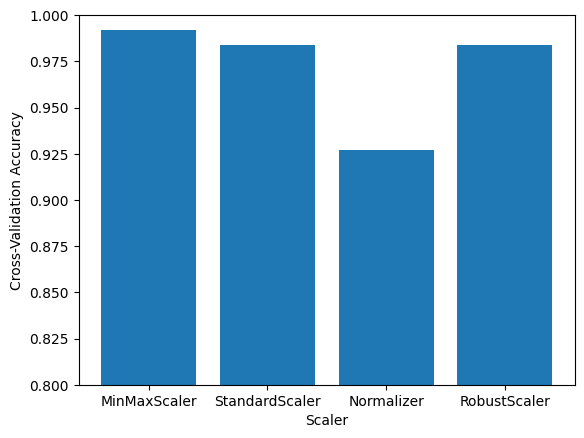

In [88]:
wine_super_pipes: dict[str, Super_Pipeline] = {
	"MinMaxScaler": wine_super_pipe_minmax,
	"StandardScaler": wine_super_pipe_standard,
	"Normalizer": wine_super_pipe_normalizer,
	"RobustScaler": wine_super_pipe_robust
}

plt.bar(wine_super_pipes.keys(), [pipe.best_score for pipe in wine_super_pipes.values()])
plt.ylabel("Cross-Validation Accuracy")
plt.xlabel("Scaler")
plt.ylim(0.8, 1.0)
plt.show()

#### Best Parameters

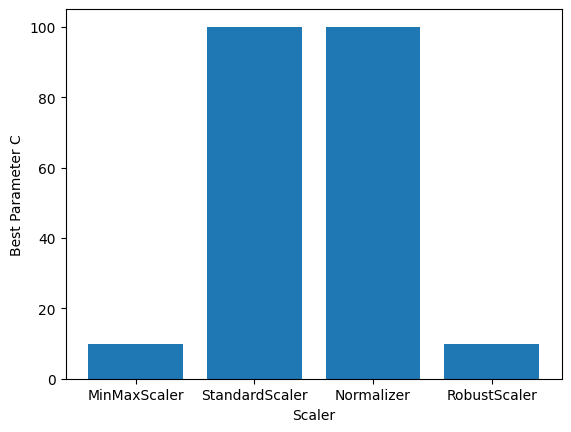

In [89]:
best_params: dict[str, float] = {key: pipe.best_params['svc__C'] for key, pipe in wine_super_pipes.items()}
plt.bar(best_params.keys(), best_params.values())
plt.ylabel("Best Parameter C")
plt.xlabel("Scaler")
plt.show()

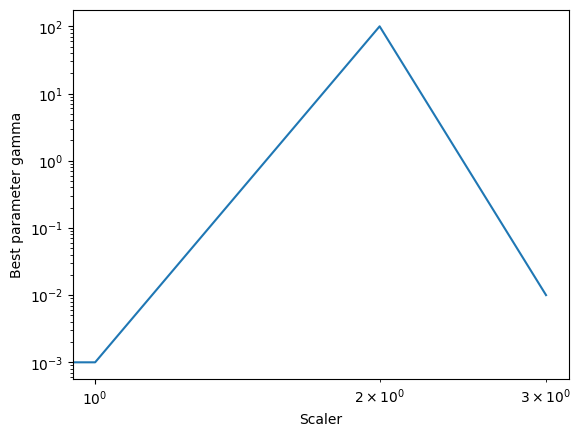

In [90]:
best_params: dict[str, float] = {key: pipe.best_params['svc__gamma'] for key, pipe in wine_super_pipes.items()}
plt.loglog(best_params.keys(), best_params.values())
plt.ylabel("Best parameter gamma")
plt.xlabel("Scaler")
plt.xscale("log")
plt.show()

#### Test Set Score

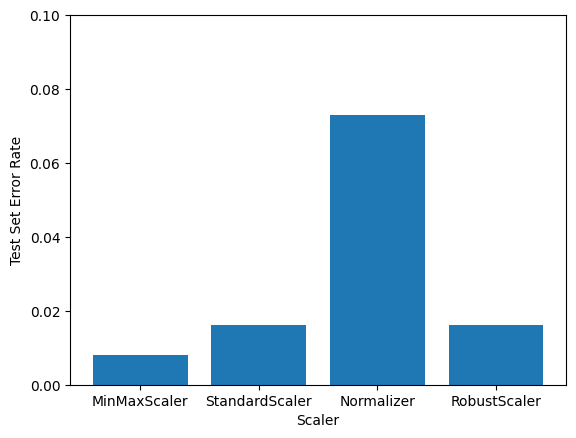

In [91]:
error_rates: dict[str, float] = {key: pipe.error_rate for key, pipe in wine_super_pipes.items()}
plt.bar(error_rates.keys(), error_rates.values())
plt.ylabel("Test Set Error Rate")
plt.xlabel("Scaler")
plt.ylim(0, 0.1)
plt.show()


## USPS Dataset

### MinMax Scaler

In [92]:
zip_super_pipe_minmax: Super_Pipeline = Super_Pipeline(param_grid, MinMaxScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test)
print(zip_super_pipe_minmax)

Best Cross-Validation Score: 0.7373737373737373
Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001}
Test Set Score: 0.5862068965517241
Test Set Error Rate: 0.26262626262626265


### Standard Scaler

In [93]:
zip_super_pipe_standard: Super_Pipeline = Super_Pipeline(param_grid, StandardScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test)
print(zip_super_pipe_standard)

Best Cross-Validation Score: 0.7070707070707071
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.001}
Test Set Score: 0.5517241379310345
Test Set Error Rate: 0.29292929292929293


### Normalizer

In [94]:
zip_super_pipe_robust: Super_Pipeline = Super_Pipeline(param_grid, RobustScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test)
print(zip_super_pipe_robust)

Best Cross-Validation Score: 0.4437229437229437
Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001}
Test Set Score: 0.5862068965517241
Test Set Error Rate: 0.5562770562770563


### Robust Scaler

In [95]:
zip_super_pipe_normalizer: Super_Pipeline = Super_Pipeline(param_grid, Normalizer, X_zip_train, y_zip_train, X_zip_test, y_zip_test)
print(zip_super_pipe_normalizer)

Best Cross-Validation Score: 0.7532467532467533
Best Parameters: {'svc__C': 100, 'svc__gamma': 0.1}
Test Set Score: 0.5862068965517241
Test Set Error Rate: 0.24675324675324672


### Comparison

#### Best Cross-Validation Score

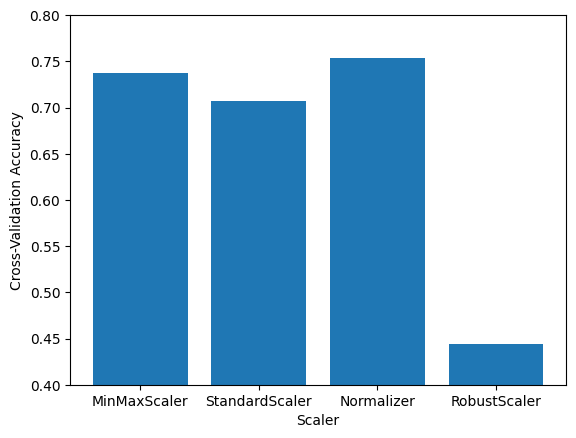

In [96]:
zip_super_pipes: dict[str, Super_Pipeline] = {
	"MinMaxScaler": zip_super_pipe_minmax,
	"StandardScaler": zip_super_pipe_standard,
	"Normalizer": zip_super_pipe_normalizer,
	"RobustScaler": zip_super_pipe_robust
}

plt.bar(zip_super_pipes.keys(), [pipe.best_score for pipe in zip_super_pipes.values()])
plt.ylabel("Cross-Validation Accuracy")
plt.xlabel("Scaler")
plt.ylim(0.4, 0.8)
plt.show()

#### Best Parameters

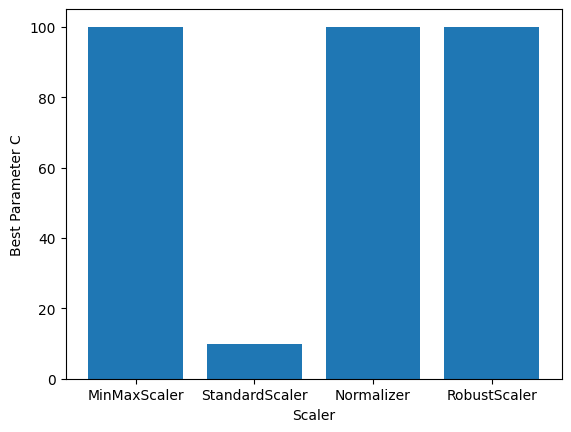

In [97]:
best_params: dict[str, float] = {key: pipe.best_params['svc__C'] for key, pipe in zip_super_pipes.items()}
plt.bar(best_params.keys(), best_params.values())
plt.ylabel("Best Parameter C")
plt.xlabel("Scaler")
plt.show()

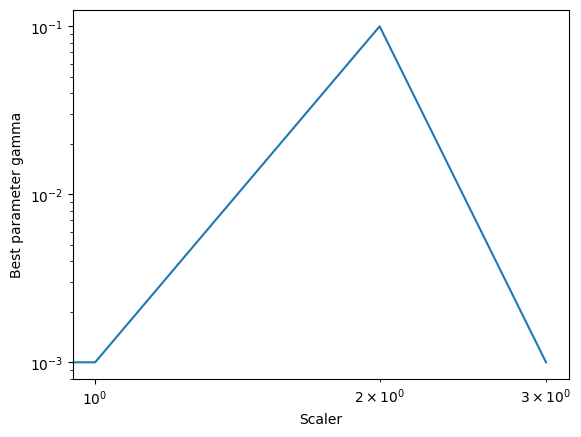

In [98]:
best_params: dict[str, float] = {key: pipe.best_params['svc__gamma'] for key, pipe in zip_super_pipes.items()}
plt.loglog(best_params.keys(), best_params.values())
plt.ylabel("Best parameter gamma")
plt.xlabel("Scaler")
plt.xscale("log")
plt.show()

#### Test Set Score

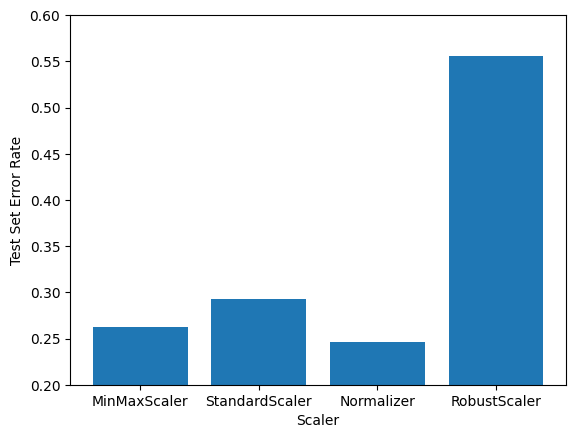

In [99]:
error_rates: dict[str, float] = {key: pipe.error_rate for key, pipe in zip_super_pipes.items()}
plt.bar(error_rates.keys(), error_rates.values())
plt.ylabel("Test Set Error Rate")
plt.xlabel("Scaler")
plt.ylim(0.2, 0.6)
plt.show()

# 6 - Predict Test Labels

## Wine Dataset

### MinMax Scaler

In [100]:
print("Test Set Score: ", wine_super_pipe_minmax.test_score)

Test Set Score:  0.9814814814814815


### Standard Scaler

In [101]:
print("Test Set Score: ", wine_super_pipe_standard.test_score)

Test Set Score:  0.9814814814814815


### Normalizer

In [102]:
print("Test Set Score: ", wine_super_pipe_normalizer.test_score)

Test Set Score:  0.9629629629629629


### Robust Scalar

In [103]:
print("Test Set Score: ", wine_super_pipe_robust.test_score)

Test Set Score:  0.9814814814814815


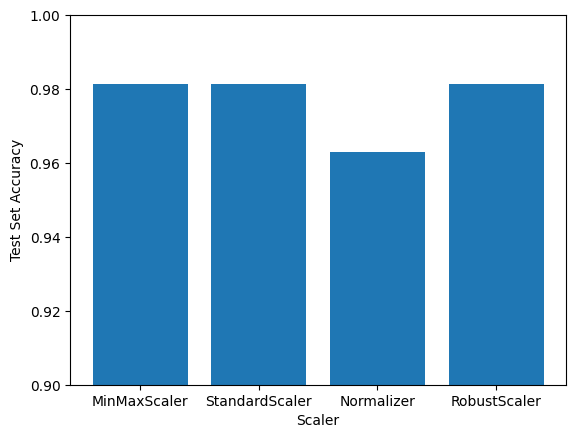

In [104]:
plt.bar(wine_super_pipes.keys(), [pipe.test_score for pipe in wine_super_pipes.values()])
plt.ylabel("Test Set Accuracy")
plt.xlabel("Scaler")
plt.ylim(0.9, 1.0)
plt.show()

## Zip Dataset

### MinMax Scaler

In [105]:
print("Test Set Score: ", zip_super_pipe_standard.test_score)

Test Set Score:  0.5517241379310345


### Standard Scaler

In [106]:
print("Test Set Score: ", zip_super_pipe_standard.test_score)

Test Set Score:  0.5517241379310345


### Normalizer

In [107]:
print("Test Set Score: ", zip_super_pipe_normalizer.test_score)

Test Set Score:  0.5862068965517241


### Robust Scaler

In [108]:
print("Test Set Score: ", zip_super_pipe_robust.test_score)

Test Set Score:  0.5862068965517241


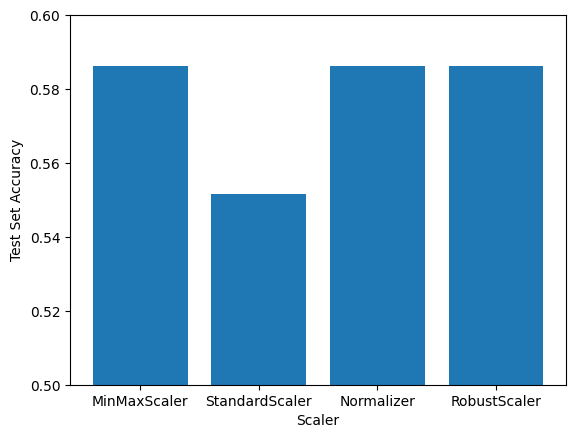

In [109]:
plt.bar(zip_super_pipes.keys(), [pipe.test_score for pipe in zip_super_pipes.values()])
plt.ylabel("Test Set Accuracy")
plt.xlabel("Scaler")
plt.ylim(0.5, 0.6)
plt.show()

# 7 - Cross-Conformal Prediction